### **Mount Google Drive/Parent Directory**

In [1]:
# !pip install google
# !pip install nibabel

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### **Install and Import Libraries**

In [40]:
# Library to read .nii Images
# !pip install nibabel
# !pip install pydicom

In [4]:
import cv2
import copy
import numpy as np
import numpy as np                                            
import matplotlib.pyplot as plt                 
from scipy.stats import multivariate_normal
import random  
import time  
import pydicom
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
# Library to read .nii Images
import nibabel as nib
import pandas as pd
import os
from glob import glob
import math
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation

**Image Slice Visualization**

In [5]:
# Visualize 2D Slice from 3D Image
def slice_show(image, slice_no, title):
    """
    Inputs: 
    image => Nifti Image that need to be visualized,
    slice_no => Slice Number from 1 to 48
    title => The title of the Image
    
    output: Plot Image.

    """ 
    plt.figure()
    plt.axis('off')
    plt.title(title)
    plt.imshow(image[:,:,slice_no].T, cmap='gray') # Transpose the slice image from the one read by Nibabel as we want to see vertical image

### **Evaluation Metric (TRE)**

In [6]:
def computeTRE(transformed, target, voxel_size):
  """
  Inputs: 
  transformed => contains the transformed landmarks coordinates in x,y and z dimension,
  target => contains the landmarks coordinates of target image in x,y and z dimension,
  voxel_size => voxel spacing in x,y and z dimension
  
  output: return the TRE error per each pair of the landmark point.

  """ 

  x_diff_sqr =  pow(((transformed[0] - target[0])*voxel_size[0]),2)
  y_diff_sqr =  pow(((transformed[1] - target[1])*voxel_size[1]),2)
  z_diff_sqr =  pow(((transformed[2] - target[2])*voxel_size[2]),2)

  tre_error = math.sqrt(x_diff_sqr + y_diff_sqr + z_diff_sqr) # 3D Eucledian Distance Computation

  return tre_error

In [7]:
def computeTRE_MeanStd(transformed_landmarks, target_landmarks, voxel_size):
  """
  Inputs: 
  transformed_landmarks => a list of the transformed landmark points,
  target_landmarks => a list of the target image landmark points,
  voxel_size => voxel spacing in x,y and z dimension
  
  output: return the mean and std of TRE error per pair of the given two images.

  """ 
  all_tre = [] # A list which will hold all the TRE per point
  for i in range(len(transformed_landmarks)):
    temp_tre = computeTRE(transformed_landmarks[i], target_landmarks[i], voxel_size)
    all_tre.append(temp_tre)
  mean_tre = np.mean(all_tre) # mean
  std_tre = np.std(all_tre) # standard deviation
  return mean_tre, std_tre

### **Data Loading**

In [30]:
# Directories of the images and landmarks
input_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MIRA/'
train_directory = input_directory+'train' 
val_directory = input_directory+'val'
test_directory = input_directory+'test'
seg_directory = input_directory+'seg'

In [32]:
def loadData(directory):
  """
  Inputs: 
  directory => the place where train/validation/test images and landmarks are stored,

  output: 
  inhale_images => list of the inhale images of all the patient,
  inhale_landmarks => list of the inhale image landmarks of all the patient,
  exhale_images => list of the exhale images of all the patient,
  exhale_landmarks => list of the exhale image landmarks of all the patient,
  voxel_size_list => list of the voxel dimensions of the images of all the patient,

  """
  inhale_images = []
  inhale_landmarks = []
  exhale_images = []
  exhale_landmarks = []
  voxel_size_list = []

  for folders in sorted(os.listdir(directory)):
    images_directory = os.path.join(directory, folders) # Accessing each patient folder
    for files in sorted(os.listdir(images_directory)):
      if '.txt' in files: # Accessing each landmark files
        if '_eBH' in files: # Accessing each exhale landmark files
          with open(os.path.join(images_directory, files)) as f:
            exhale_landmarks_raw = []
            for line in f:
              
              exhale_landmarks_raw.append([float(n) for n in line.strip().split('\t')]) # Converting the text file to a list of points
            exhale_landmarks.append(exhale_landmarks_raw)
        else: # Accessing each inhale landmark files
          with open(os.path.join(images_directory, files)) as f:
            inhale_landmarks_raw = []
            for line in f:
              inhale_landmarks_raw.append([float(n) for n in line.strip().split('\t')]) # Converting the text file to a list of points
            inhale_landmarks.append(inhale_landmarks_raw)
      else:
        if '_eBH' in files: # Accessing each exhale image files
          exhale_img_data = nib.load(os.path.join(images_directory, files)) # reading the .nii image
          sx, sy, sz = exhale_img_data.header.get_zooms() # getting the voxel dimension
          voxel_size = [sx, sy, sz]
          voxel_size_list.append(voxel_size)
          exhale_img = exhale_img_data.get_fdata()
          exhale_images.append(exhale_img)
        else: # Accessing each inhale image files
          inhale_img_data = nib.load(os.path.join(images_directory, files)) # reading the .nii image
          inhale_img = inhale_img_data.get_fdata()
          inhale_images.append(inhale_img)
  return inhale_images, inhale_landmarks, exhale_images, exhale_landmarks, voxel_size_list

In [31]:
# Training Images and Landmarks
train_inhale_images = []
train_inhale_landmarks = []
train_exhale_images = []
train_exhale_landmarks = []
patient_voxel_size_list = []

train_inhale_images, train_inhale_landmarks, train_exhale_images, train_exhale_landmarks, patient_voxel_size_list = loadData(seg_directory)

In [33]:
for files in sorted(os.listdir(train_directory)): 
  print(files)

1
2
3
4


In [34]:
#Check
print(len(train_inhale_images))
print(len(train_inhale_landmarks))
print(len(train_exhale_images))
print(len(train_exhale_landmarks))
print(len(patient_voxel_size_list))

4
4
4
4
4


In [35]:
# Number of landmarks per image
for landmarks in train_inhale_landmarks:
  print(len(landmarks))
for landmarks in train_exhale_landmarks:
  print(len(landmarks))

300
300
300
300
300
300
300
300


### **Compute TRE**

In [36]:
for patient in range(len(train_inhale_images)): # Accessing each patient
  patient_mean_tre, patient_std_tre = computeTRE_MeanStd(train_inhale_landmarks[patient], train_exhale_landmarks[patient], patient_voxel_size_list[patient])
  print('For Patient {} The mean TRE is: {} and std of TRE is: {}'.format(patient, patient_mean_tre, patient_std_tre))

For Patient 0 The mean TRE is: 26.14727660137311 and std of TRE is: 11.337752042730125
For Patient 1 The mean TRE is: 21.640839694139274 and std of TRE is: 6.415267547626306
For Patient 2 The mean TRE is: 12.62588335216309 and std of TRE is: 6.381867428751379
For Patient 3 The mean TRE is: 29.583559738904107 and std of TRE is: 12.92417092574431


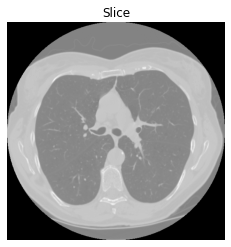

In [37]:
slice_show(train_inhale_images[0], 50,'Slice')

In [38]:
print(train_inhale_images[0].shape)

(512, 512, 121)


### **Nifti to DICOM**

### **Watershed Segmentation**

In [ ]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512, 121), dtype=int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

In [ ]:
#Show some example markers from the middle        
image = train_inhale_images[0].astype(np.int16)
image[image == -2000] = 0
slice_show(image, 50,'Slice')
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(image)
print ("Internal Marker")
slice_show(test_patient_internal, 50, 'test_patient_internal')
print ("External Marker")
slice_show(test_patient_external, 50, 'test_patient_external')
print ("Watershed Marker")
slice_show(test_patient_watershed, 50, 'test_patient_watershed')